<a href="https://colab.research.google.com/github/Camilojaravila/202120_ISIS4219_01-MACHINE_LEARNING_TECHNIQUES/blob/main/Taller/Laboratorio_I_Taller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://bloqueneon.uniandes.edu.co/content/enforced/52233-202120_ISIS4219_01/Laboratorios.png?_&d2lSessionVal=guLBE9l4cI9Tip6PM5JSzKgp6" ><br>
# Machine Learning Techniques - ISIS4219

Segundo Semestre - 2021




## Integrantes

*   Daniel Mateo Guatibonza Solano - 201611360
*   Raquel Andrea Cerda Montañez - 201533520
*   Sergio Eduardo Cárdenas Landazabal - 201613444



## **Problema**

Las enfermedades cardiovasculares son la principal causa de muerte en el mundo, y se calcula que cobran 17,9 millones de vidas al año (OMS). La enfermedad de las arterias coronarias es el tipo más común de enfermedad cardíaca y se produce debido a las obstrucciones (placa) desarrolladas en el interior de las arterias coronarias (vasos sanguíneos que alimentan los músculos del corazón). Los cardiólogos utilizan diversas técnicas de imagen y mediciones invasivas de la presión arterial para examinar y controlar la gravedad de dichas obstrucciones. <br>
Los factores de riesgo conductuales más importantes de estas enfermedades son una dieta poco saludable, la inactividad física, el consumo de tabaco y el uso nocivo del alcohol. Los efectos de los factores de riesgo pueden manifestarse en las personas en forma de aumento de la presión arterial, aumento de la glucosa en sangre, aumento de los lípidos en sangre y sobrepeso y obesidad.
Identificar a las personas con mayor riesgo de sufrir enfermedades cardiovasculares y garantizar que reciban el tratamiento adecuado puede evitar muertes prematuras. Con este objetivo en mente, se quiere utilizar las técnicas de machine learning para construir un modelo que permita predecir qué pacientes pueden estar en riesgo de padecer este tipo de cardiopatía.<br><br>
Referencias. <br>
OMS (s.f.). “Cardiovascular diseases”. https://www.who.int/health-topics/cardiovascular-diseases#tab=tab_1
<br><br>
**Fuente de Datos**: https://www.kaggle.com/agsam23/coronary-artery-disease/version/3


# Librerías necesarias
En primer lugar, se importan todas las librerías requeridas para realizar la lectura, preprocesamiento y construcción del modelo incluyendo las librerías re 

In [1]:
# Data management Libraries
import pandas as pd
import numpy as np
import sys
from pandas_profiling import ProfileReport

# Data Modeling Libraries
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.compose import ColumnTransformer

# Data visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Save the model
from joblib import dump, load

# Lectura de datos
La fuente de datos otorgada cuenta con tres archivos: el primero con los datos crudos, el segundo con los datos clasificados y el tercero con estos últimos particionados en cinco subconjuntos de forma estratificada. Considerando que en datasets reducidos, como es el caso en cuestión, es natural tomar el 20% del conjunto total para hacer pruebas sobre el modelo seleccionado (<em>test set</em>), se optó por hacer uso del último archivo con el propósito de aprovechar las particiones estratificadas y de tener así el conjunto de prueba segmentado desde un principio.

In [2]:
data_df = pd.read_csv('st_fold_data.csv')
data_df.head()

Unnamed: 0   age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  \
0           0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0   
1           1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0   
2           2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0   
3           3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0   
4           4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0   

   oldpeak  slope   ca thal  label  kfold  
0      2.3    3.0  0.0  6.0      0    0.0  
1      1.5    2.0  3.0  3.0      2    0.0  
2      2.6    2.0  2.0  7.0      1    0.0  
3      3.5    3.0  0.0  3.0      0    0.0  
4      1.4    1.0  0.0  3.0      0    0.0

# Perfilamiento de datos
Una vez importados los datos, es necesario conocer sus campos de manera general por lo que se realiza un perfilamiento de los mismos a través de la librería <em>pandas_profiling</em> que retorna de forma renderizada un reporte simple como se muestra a continuación.

In [3]:
ProfileReport(data_df)

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Preprocesamiento
Con base en el perfilamiento, fue posible evidenciar que, aunque no hay valores faltantes en ninguno de los campos, existen en total 6 registros donde uno de los atributos 'ca' o 'thal' toman el valor de '?'. Dado que esta cantidad de registros es insignificante en comparación con el tamaño del dataset inicial (303 datos), se decidió eliminar dichos registros. De igual manera, puesto que se busca identificar la presencia o ausencia de la enfermedad de las arterias coronarias independientemente de la etapa en la que se encuentra, 

In [4]:
data_df = data_df[data_df['ca'] != '?']
data_df = data_df[data_df['thal'] != '?']
data_df['label'] = (data_df['label'] > 0).astype('int32')
data_df.head()

Unnamed: 0   age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  \
0           0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0   
1           1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0   
2           2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0   
3           3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0   
4           4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0   

   oldpeak  slope   ca thal  label  kfold  
0      2.3    3.0  0.0  6.0      0    0.0  
1      1.5    2.0  3.0  3.0      1    0.0  
2      2.6    2.0  2.0  7.0      1    0.0  
3      3.5    3.0  0.0  3.0      0    0.0  
4      1.4    1.0  0.0  3.0      0    0.0

In [5]:
data_training = data_df[data_df['kfold']<4]
data_test = data_df[data_df['kfold']==4]

In [6]:
training_X = data_training.drop(['label'],axis=1)
training_Y = data_training['label']

In [7]:
ct = ColumnTransformer(transformers=[('drop', 'drop', ['Unnamed: 0', 'kfold']),
                                     ('one_hot', OneHotEncoder(handle_unknown='ignore'), ['cp','restecg','slope','ca','thal']),
                                     ('normalize', MinMaxScaler(), ['age','trestbps','chol','thalach','oldpeak'])],
                       remainder='passthrough')

In [8]:
model = Pipeline([
    ('preprocessing', ct),
    ('algoritmo',LogisticRegression(solver='liblinear'))
])

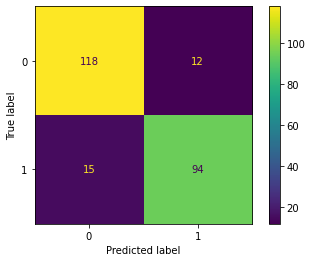

In [9]:
model.fit(training_X,training_Y)
plot_confusion_matrix(model,training_X,training_Y,values_format='d')

In [10]:
param_grid_logr = dict(algoritmo__penalty=['l2', 'elasticnet','none'],
                       algoritmo__C=[1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1],
                       algoritmo__solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                       algoritmo__max_iter=[10,20,50,100],
                       preprocessing__normalize=[MinMaxScaler(), StandardScaler()])
grid_search_logr = GridSearchCV(model,param_grid=param_grid_logr,cv=5,verbose=3,scoring='accuracy')
grid_search_logr.fit(training_X,training_Y.ravel())

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preproces

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet 

[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, a

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver sag supports only 'l2' or 'none' penalties, got elasticnet pe

[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=

x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Incr

[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=none, algori

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\pyth

[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=none, algori

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 455, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinea

[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=sa

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='n


[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=l2, algorit

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessi

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algor

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet 

[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, 

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver sag supports only 'l2' or 'none' penalties, got elasticnet pe

[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=no

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Sett

[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\pyth

[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, 

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 455, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinea

[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was 

[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=l2, algori

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__no

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=saga, prepr

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elastic

[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=elas

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver sag supports only 'l2' or 'none' penalties, got elasticnet pe

[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=elasti

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Sett

[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\pyth

[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solve

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 455, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinea

[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='n

[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=l2, al

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=saga, pre

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elastic

[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  

[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, alg

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting p

[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penal

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\pyth

[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algori

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_sel


[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, a

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_it

[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__sol

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was 

[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 


[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=sag, pr

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, al

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet 

[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, a

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver sag supports only 'l2' or 'none' penalties, got elasticnet pe

[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=el

x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Incr

[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scal

[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=none, al

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 455, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinea

[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.830 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__s

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was 

[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.830 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=l2, algor

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=saga,

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elastic

[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__pena

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  

[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=el

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Sett

[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__pe

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\pyth

[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritm

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 455, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinea

[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algo

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was 

[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solv

[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__pena

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elastic

[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  

[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penal

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for the

[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__pe

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning

[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=none, al

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='n

[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solve

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='n

[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritm

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elastic

[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritm

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  


[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=1

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for the

[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo_

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, 

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarn

[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=no

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='n

[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo_

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='n

[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__max_iter=100, algoritmo__penalty=none, alg

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 


[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.625 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.667 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.617 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preproc

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=10, a

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet 

[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=1

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver sag supports only 'l2' or 'none' penalties, got elasticnet pe


[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalt

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will igno

[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=none, 

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\pyth

[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=none, algori

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was 


[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.830 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=sag

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='n

[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.583 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.646 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=l2, algori

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elastic

[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algor

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  

[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=elast

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for the

[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning

[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritm

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='n

[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=s

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.583 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritm

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elastic

[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__pena

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  

[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=elasti

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for the

[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__pena

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning

[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__s

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scal

[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solve

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='n

[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=sag

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='n

[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.583 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.646 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.625 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=l2

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elastic

[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algor

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  

[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=el

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for the

[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algorit

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning

[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algori

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Sett

[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algo

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='n

[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solv

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='n

[CV 5/5] END algoritmo__C=0.001, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solv

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logi

[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=lbfgs, preproc

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=elas

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet 

[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, 

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver sag supports only 'l2' or 'none' penalties, got elasticnet pe

x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Incr

[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=none

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\pyth


[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__so

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='n

[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.830 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.875 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=sag, prepr

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='n

[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.938 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.830 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=n

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elastic

[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalt

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  

[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritm

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for the

[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, al

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning

[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfg

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\pyth

[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solve

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='n

[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, pre

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.875 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.708 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.766 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=l2, algori

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elastic

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  

[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algor

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for the

[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=none,

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__s

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\pyth

[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__sol

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='n

[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, p

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was 

[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__sol

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elastic

[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  

[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=elasticnet

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for the

[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=no

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarn

[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritm

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='n

[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=s

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was 

[CV 3/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=n

x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iteration

[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.938 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=lbfgs, preprocessi

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logi

[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=0.938 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solve

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.938 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__norma

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py

[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__pe

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet 

[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for the

[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=none, algori

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will igno

[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\pyth

[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__s

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='n

[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=saga, preprocessi

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.830 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.938 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__sol

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.938 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=ne

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\pyt

[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=el

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  

[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritm

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for the

[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=none, 

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=li

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most rece

[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=sag, preprocessi

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='n

[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.938 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=newton

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. T

[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalt

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet 

[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algori

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver sag supports only 'l2' or 'none' penalties, got elasticnet pe

[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritm

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Sett

[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, pre

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scal

[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__sol

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 455, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinea

[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocess

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='n

[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.938 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.830 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__sol

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elastic

[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=el

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  

[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for the

[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\pyth

[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lb

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_sel

[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritm

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_it

[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, pr

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='n

[CV 4/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=newton-cg, p

x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iteration

[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.830 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=lbfgs, preprocessing__normaliz

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logi

[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=0.938 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=liblinear,

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 


[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.938 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxS

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=el

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet 

[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalt

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver sag supports only 'l2' or 'none' penalties, got elasticnet pe

[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=ne

x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iteration

[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.1s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logi

[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=liblinear, pre

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.938 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=10, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__norma

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logi

[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.809 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=lbfgs, preprocessing__normalize=

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=Standa

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__sol

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet 

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver sag supports only 'l2' or 'none' penalties, got elasticnet pe

[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=elasticnet, algoritmo__solver=

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logi

[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessi

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 455, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinea

[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=Stan

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=20, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 


[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.809 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.938 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=sag, preprocessing__normalize=StandardS

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.938 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.830 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessin

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet 

[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo_

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver sag supports only 'l2' or 'none' penalties, got elasticnet pe

[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=elasticnet, algoritmo__solve

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logi

[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessi

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 455, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinea

[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=sag, preprocessi

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=50, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normaliz

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.809 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=newton

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.809 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=l2, algoritmo__solver=saga, preprocessing__normalize=Stan

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py

[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=newton-cg, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__pena

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet 

[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=liblinear, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver sag supports only 'l2' or 'none' penalties, got elasticnet pe

[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=elasticnet, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=newton-cg, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__so

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logi

[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=lbfgs, preprocessing__normalize=StandardScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=liblinear, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=liblinea

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 455, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinea

[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=sag, preprocessing__no

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 


[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=MinMaxScaler();, score=0.872 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__max_iter=100, algoritmo__penalty=none, algoritmo__solver=saga, preproce

x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.54397163 0.54397163 0.54397163 0.54397163 0.83235816 0.78652482
 0.54397163 0.54397163 0.54397163 0.54397163        nan        nan
        nan        nan        nan        nan        nan        nan
 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['Unnamed: '
                                                                          '0',
                                                                          'kfold']),
                                                                        ('one_hot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['cp',
                                                                          'restecg',
                                                                   

In [11]:
print(grid_search_logr.best_params_)

{'algoritmo__C': 0.1, 'algoritmo__max_iter': 10, 'algoritmo__penalty': 'none', 'algoritmo__solver': 'sag', 'preprocessing__normalize': StandardScaler()}


In [12]:
display(pd.DataFrame(grid_search_logr.cv_results_))

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.009948      0.000635         0.004598        0.000484   
1         0.010191      0.000691         0.004024        0.000005   
2         0.009562      0.001203         0.004498        0.000447   
3         0.009366      0.000496         0.004091        0.000488   
4         0.010159      0.004111         0.004993        0.001256   
..             ...           ...              ...             ...   
715       0.006996      0.000633         0.000000        0.000000   
716       0.011951      0.000883         0.004189        0.000399   
717       0.013444      0.001757         0.004404        0.000815   
718       0.012554      0.000476         0.004190        0.000386   
719       0.013367      0.000478         0.004378        0.000475   

    param_algoritmo__C param_algoritmo__max_iter param_algoritmo__penalty  \
0              0.00001                        10                       l2   
1              0.00001                        10                       l2   
2              0.00001                        10                       l2   
3              0.00001                        10                       l2   
4              0.00001                        10                       l2   
..                 ...                       ...                      ...   
715                  1                       100                     none   
716                  1                       100                     none   
717                  1                       100                     none   
718                  1                       100                     none   
719                  1                       100                     none   

    param_algoritmo__solver param_preprocessing__normalize  \
0                 newton-cg                 MinMaxScaler()   
1                 newton-cg               StandardScaler()   
2                     lbfgs                 MinMaxScaler()   
3                     lbfgs               StandardScaler()   
4                 liblinear                 MinMaxScaler()   
..                      ...                            ...   
715               liblinear               StandardScaler()   
716                     sag                 MinMaxScaler()   
717                     sag               StandardScaler()   
718                    saga                 MinMaxScaler()   
719                    saga               StandardScaler()   

                                                params  split0_test_score  \
0    {'algoritmo__C': 1e-05, 'algoritmo__max_iter':...           0.541667   
1    {'algoritmo__C': 1e-05, 'algoritmo__max_iter':...           0.541667   
2    {'algoritmo__C': 1e-05, 'algoritmo__max_iter':...           0.541667   
3    {'algoritmo__C': 1e-05, 'algoritmo__max_iter':...           0.541667   
4    {'algoritmo__C': 1e-05, 'algoritmo__max_iter':...           0.833333   
..                                                 ...                ...   
715  {'algoritmo__C': 1, 'algoritmo__max_iter': 100...                NaN   
716  {'algoritmo__C': 1, 'algoritmo__max_iter': 100...           0.833333   
717  {'algoritmo__C': 1, 'algoritmo__max_iter': 100...           0.833333   
718  {'algoritmo__C': 1, 'algoritmo__max_iter': 100...           0.833333   
719  {'algoritmo__C': 1, 'algoritmo__max_iter': 100...           0.833333   

     split1_test_score  split2_test_score  split3_test_score  \
0             0.541667           0.541667           0.541667   
1             0.541667           0.541667           0.541667   
2             0.541667           0.541667           0.541667   
3             0.541667           0.541667           0.541667   
4             0.875000           0.895833           0.791667   
..                 ...                ...                ...   
715                NaN                NaN                NaN   
716           0.812500           0.895833           0.770833   
717  

In [13]:
model = Pipeline([
    ('preprocessing', ct),
    ('algoritmo',SVC(tol=1e-4))
])
param_grid_SVM = dict(algoritmo__kernel=['linear','poly','rbf','sigmoid','precomputed'],
                       algoritmo__C=[1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.5, 1],
                       algoritmo__gamma=['scale','auto'],
                       algoritmo__max_iter=[10,20,50,100],
                       preprocessing__normalize=[MinMaxScaler(), StandardScaler()])
grid_search_SVM = GridSearchCV(model,param_grid=param_grid_SVM,cv=5,verbose=3,scoring='accuracy')
grid_search_SVM.fit(training_X,training_Y.ravel())

Fitting 5 folds for each of 560 candidates, totalling 2800 fits
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.688 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.702 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, alg

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.702 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.708 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.750 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__ma

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.708 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.766 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=linear, algorit

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.604 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, 

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.583 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.479 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20,

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.625 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.702 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=1

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.708 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.830 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessi

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.750 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.646 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.500 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.723 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, p

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)



[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.688 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.708 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.723 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.646 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritm

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37


[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.723 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.604 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.729 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.708 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.646 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, al

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.646 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, alg

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a

[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=precom

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 191x25 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 191x25 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=scale, algoritmo__kernel=prec

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.702 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.729 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=1

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.750 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.479 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.681 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.745 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.438 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, prepr

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.417 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.511 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=50, prepr

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, p

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.708 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.723 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=20, preproc

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.766 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.729 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.938 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.702 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_it

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a

[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algo

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 191x25 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=precomputed, a

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 191x25 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1e-05, algoritmo__gamma=auto, algoritmo__kernel=preco

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.702 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.646 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.766 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=linear, a

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.479 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.417 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.511 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__ma

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.830 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.625 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=1

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.723 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, pre

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_ite

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 3/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.708 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.723 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid,

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 3/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.688 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.766 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.667 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, a

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 191x25 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__ker

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 191x25 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.688 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kern

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.702 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.708 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.766 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritm

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.604 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.745 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, prepr

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.479 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.417 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.511 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.708 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.723 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=20, pre

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.766 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.729 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preproces

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_i

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.702 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.708 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.646 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.667 total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algor

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 191x25 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=precom

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 191x25 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 5/5] END algoritmo__C=0.0001, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.688 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.688 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.702 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.708 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.750 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.479 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo_

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.745 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.438 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10,

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.417 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.511 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=50,

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python3

[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.625 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.702 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=20, p

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.723 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preproces

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.723 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.708 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.688 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.766 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.667 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.646 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, alg

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a

[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=precompu

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 191x25 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=scale, algoritmo__kernel=precompute

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 192x24 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.688 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.688 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.702 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10,

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.708 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.750 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.479 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.681 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__ma

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_it

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.604 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.745 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preproc

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.417 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.511 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=50, prepr

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, p

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.708 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.723 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=20, preproces

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.766 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__no

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.702 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.708 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__ma

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.667 total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a

[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=precomputed,

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 192x24 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=precompu

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 191x25 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 2/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.001, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.688 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=linear,

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.702 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.875 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.750 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.766 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.688 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.745 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessi

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.479 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.417 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.511 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=50, p

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python

[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.688 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.688 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.723 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, pre

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.625 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.702 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=20, preproc

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.830 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__no

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.708 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.723 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.708 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__ma

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.688 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.667 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a

[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=precomputed, 

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 192x24 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=scale, algoritmo__kernel=precomputed,

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 191x25 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.688 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.702 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, prepr

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.500 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.766 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.766 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.938 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=100

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.745 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.438 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.479 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preproces

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.417 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.511 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python3

[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preproc

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.708 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.723 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.766 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normaliz

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.702 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.708 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.708 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.667 total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a

[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algori

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 191x25 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=precomputed, a

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 191x25 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 4/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.01, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_it

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.708 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.702 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.958 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20,

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.830 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=10

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\pyth

[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.468 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessi

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.438 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.447 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.938 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.809 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.750 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preproc

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.750 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.625 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.702 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.750 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.830 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normal

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python

[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.875 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.667 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.766 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, prep

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.708 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.688 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.723 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20,

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.729 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.708 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.830 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__ma

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be 

[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritm

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 191x25 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 192x24 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.688 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.660 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessi

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.958 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.723 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=50, p

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.830 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=100, pre

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\pytho

[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.438 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.479 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.468 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.830 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normaliz

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preproces

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python3

[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.723 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=Mi

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.766 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.729 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normaliz

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python3

[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.766 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.688 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preproce

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.625 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.681 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, pre

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.708 total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 191x25 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 


[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo_

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 191x25 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 3/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.1, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.396 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.745 total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.667 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, p

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\pytho

[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.521 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.604 total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.354 total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.681 total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__no

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.521 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.479 total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.447 total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=50, preproc

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocess

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\pyth


[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.830 total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.750 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.625 total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing_

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.688 total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.723 total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__no

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__no

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\pyth

[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.723 total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.729 total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.688 total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.745 total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\p

[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algorit

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 191x25 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=scale, algoritmo__kernel=precomputed, al

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 191x25 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.625 total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.660 total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preproc

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.830 total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=50, prepr

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python

[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.809 total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.583 total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.479 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__no

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.447 total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing_

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\pyth

[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.750 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.708 total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.766 total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.708 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=St

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.750 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.479 total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normal

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.809 total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normal

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python3

[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.702 total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=2

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.809 total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, prepr

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\p

[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.809 total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.938 total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_i

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 191x25 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 191x25 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=0.5, algoritmo__gamma=auto, algoritmo__kernel=precomputed, al

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.562 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.562 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.681 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__no

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 5/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.809 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.479 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.688 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.583 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 5/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.830 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.500 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.500 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normal

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 5/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.809 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normali

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\pyth

[CV 5/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.688 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.708 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=St

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 5/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.660 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxSc

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\pyth

[CV 3/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.766 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 2/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.553 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.771 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, pre

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 3/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.667 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.745 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preproc

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 

[CV 3/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 191x25 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 4/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=scale, algoritmo__kernel=precomputed, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.667 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.562 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=10, preproces

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 4/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.562 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=0.681 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=20, preprocessing__no

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 3/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.708 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.745 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=linear, algoritmo__max_iter=100, preprocessing_

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\pytho

[CV 2/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.745 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=10, preprocessing__normalize=Standard

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 1/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.479 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.458 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.438 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.447 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 5/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=50, preprocessing__normalize=StandardScaler();, score=0.447 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.562 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=poly, algoritmo__max_iter=100, preprocessing__normalize=Min

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\pyth

[CV 4/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.708 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=MinMaxScaler();, score=0.766 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.625 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.562 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=10, preprocessing__normalize=StandardSc

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 4/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.646 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 2/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.830 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=rbf, algoritmo__max_iter=100, preprocessing__normalize=Standard

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python

[CV 1/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.625 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.542 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.646 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=10, preprocessing__normalize=StandardScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preproc

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37

[CV 5/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=0.830 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.875 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=50, preprocessing__

x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
x:\programas\python\python3

[CV 5/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=MinMaxScaler();, score=0.851 total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.938 total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=sigmoid, algoritmo__max_iter=100, pre

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 191x25 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

[CV 4/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 5/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=MinMaxScaler();, score=nan total time=   0.0s
[CV 1/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=20, preprocessing__normalize=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END algoritmo__C=1, algoritmo__gamma=auto, algoritmo__kernel=precomputed, algoritmo__max_iter=2

x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "x:\programas\python\python37\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "x:\programas\python\python37\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    .format(X.shape[0], X.shape[1]))
ValueError: Precomputed matrix must be a square matrix. Input is a 192x24 matrix.

  FitFailedWarning)
x:\programas\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['Unnamed: '
                                                                          '0',
                                                                          'kfold']),
                                                                        ('one_hot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['cp',
                                                                          'restecg',
                                                                   

In [14]:
print(grid_search_SVM.best_params_)

{'algoritmo__C': 0.1, 'algoritmo__gamma': 'scale', 'algoritmo__kernel': 'poly', 'algoritmo__max_iter': 100, 'preprocessing__normalize': MinMaxScaler()}


In [15]:
display(pd.DataFrame(grid_search_SVM.cv_results_))

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.010565      0.001741         0.005591        0.001188   
1         0.007578      0.000488         0.003988        0.000004   
2         0.007379      0.000488         0.004388        0.000489   
3         0.008179      0.001164         0.004208        0.000438   
4         0.007888      0.000180         0.004181        0.000384   
..             ...           ...              ...             ...   
555       0.007572      0.000492         0.000000        0.000000   
556       0.006776      0.000745         0.000000        0.000000   
557       0.007580      0.000814         0.000000        0.000000   
558       0.007190      0.000383         0.000000        0.000000   
559       0.007382      0.000479         0.000000        0.000000   

    param_algoritmo__C param_algoritmo__gamma param_algoritmo__kernel  \
0              0.00001                  scale                  linear   
1              0.00001                  scale                  linear   
2              0.00001                  scale                  linear   
3              0.00001                  scale                  linear   
4              0.00001                  scale                  linear   
..                 ...                    ...                     ...   
555                  1                   auto             precomputed   
556                  1                   auto             precomputed   
557                  1                   auto             precomputed   
558                  1                   auto             precomputed   
559                  1                   auto             precomputed   

    param_algoritmo__max_iter param_preprocessing__normalize  \
0                          10                 MinMaxScaler()   
1                          10               StandardScaler()   
2                          20                 MinMaxScaler()   
3                          20               StandardScaler()   
4                          50                 MinMaxScaler()   
..                        ...                            ...   
555                        20               StandardScaler()   
556                        50                 MinMaxScaler()   
557                        50               StandardScaler()   
558                       100                 MinMaxScaler()   
559                       100               StandardScaler()   

                                                params  split0_test_score  \
0    {'algoritmo__C': 1e-05, 'algoritmo__gamma': 's...           0.687500   
1    {'algoritmo__C': 1e-05, 'algoritmo__gamma': 's...           0.729167   
2    {'algoritmo__C': 1e-05, 'algoritmo__gamma': 's...           0.854167   
3    {'algoritmo__C': 1e-05, 'algoritmo__gamma': 's...           0.708333   
4    {'algoritmo__C': 1e-05, 'algoritmo__gamma': 's...           0.812500   
..                                                 ...                ...   
555  {'algoritmo__C': 1, 'algoritmo__gamma': 'auto'...                NaN   
556  {'algoritmo__C': 1, 'algoritmo__gamma': 'auto'...                NaN   
557  {'algoritmo__C': 1, 'algoritmo__gamma': 'auto'...                NaN   
558  {'algoritmo__C': 1, 'algoritmo__gamma': 'auto'...                NaN   
559  {'algoritmo__C': 1, 'algoritmo__gamma': 'auto'...                NaN   

     split1_test_score  split2_test_score  split3_test_score  \
0             0.791667           0.770833           0.729167   
1             0.770833           0.916667           0.687500   
2             0.812500           0.812500           0.833333   
3             0.750000           0.854167           0.479167   
4             0.812500           0.770833           0.770833   
..                 ...                ...                ...   
555                NaN                NaN                NaN   
556                NaN                NaN                NaN   
557                NaN       

In [16]:
model = Pipeline([
    ('preprocessing', ct),
    ('algoritmo', KNeighborsClassifier())
])
param_grid_KNN = dict(algoritmo__n_neighbors=[3,5,9,15,25],
                       algoritmo__weights=['uniform','distance'],
                       algoritmo__algorithm=['auto','ball_tree','kd_tree','brute'],
                       preprocessing__normalize=[MinMaxScaler(), StandardScaler()])
grid_search_KNN = GridSearchCV(model,param_grid=param_grid_KNN,cv=5,verbose=3,scoring='accuracy')
grid_search_KNN.fit(training_X,training_Y.ravel())

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END algoritmo__algorithm=auto, algoritmo__n_neighbors=3, algoritmo__weights=uniform, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 2/5] END algoritmo__algorithm=auto, algoritmo__n_neighbors=3, algoritmo__weights=uniform, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 3/5] END algoritmo__algorithm=auto, algoritmo__n_neighbors=3, algoritmo__weights=uniform, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 4/5] END algoritmo__algorithm=auto, algoritmo__n_neighbors=3, algoritmo__weights=uniform, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__algorithm=auto, algoritmo__n_neighbors=3, algoritmo__weights=uniform, preprocessing__normalize=MinMaxScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__algorithm=auto, algoritmo__n_neighbors=3, algoritmo__weights=uniform, preproces

[CV 1/5] END algoritmo__algorithm=auto, algoritmo__n_neighbors=15, algoritmo__weights=uniform, preprocessing__normalize=MinMaxScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__algorithm=auto, algoritmo__n_neighbors=15, algoritmo__weights=uniform, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 3/5] END algoritmo__algorithm=auto, algoritmo__n_neighbors=15, algoritmo__weights=uniform, preprocessing__normalize=MinMaxScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__algorithm=auto, algoritmo__n_neighbors=15, algoritmo__weights=uniform, preprocessing__normalize=MinMaxScaler();, score=0.792 total time=   0.0s
[CV 5/5] END algoritmo__algorithm=auto, algoritmo__n_neighbors=15, algoritmo__weights=uniform, preprocessing__normalize=MinMaxScaler();, score=0.809 total time=   0.0s
[CV 1/5] END algoritmo__algorithm=auto, algoritmo__n_neighbors=15, algoritmo__weights=uniform, preprocessing__normalize=StandardScaler();, score=0.854 total tim

[CV 5/5] END algoritmo__algorithm=ball_tree, algoritmo__n_neighbors=3, algoritmo__weights=distance, preprocessing__normalize=MinMaxScaler();, score=0.766 total time=   0.0s
[CV 1/5] END algoritmo__algorithm=ball_tree, algoritmo__n_neighbors=3, algoritmo__weights=distance, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 2/5] END algoritmo__algorithm=ball_tree, algoritmo__n_neighbors=3, algoritmo__weights=distance, preprocessing__normalize=StandardScaler();, score=0.729 total time=   0.0s
[CV 3/5] END algoritmo__algorithm=ball_tree, algoritmo__n_neighbors=3, algoritmo__weights=distance, preprocessing__normalize=StandardScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__algorithm=ball_tree, algoritmo__n_neighbors=3, algoritmo__weights=distance, preprocessing__normalize=StandardScaler();, score=0.667 total time=   0.0s
[CV 5/5] END algoritmo__algorithm=ball_tree, algoritmo__n_neighbors=3, algoritmo__weights=distance, preprocessing__normalize=St

[CV 3/5] END algoritmo__algorithm=ball_tree, algoritmo__n_neighbors=15, algoritmo__weights=uniform, preprocessing__normalize=StandardScaler();, score=0.917 total time=   0.0s
[CV 4/5] END algoritmo__algorithm=ball_tree, algoritmo__n_neighbors=15, algoritmo__weights=uniform, preprocessing__normalize=StandardScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__algorithm=ball_tree, algoritmo__n_neighbors=15, algoritmo__weights=uniform, preprocessing__normalize=StandardScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__algorithm=ball_tree, algoritmo__n_neighbors=15, algoritmo__weights=distance, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__algorithm=ball_tree, algoritmo__n_neighbors=15, algoritmo__weights=distance, preprocessing__normalize=MinMaxScaler();, score=0.938 total time=   0.0s
[CV 3/5] END algoritmo__algorithm=ball_tree, algoritmo__n_neighbors=15, algoritmo__weights=distance, preprocessing__normalize=M

[CV 5/5] END algoritmo__algorithm=kd_tree, algoritmo__n_neighbors=5, algoritmo__weights=uniform, preprocessing__normalize=MinMaxScaler();, score=0.809 total time=   0.0s
[CV 1/5] END algoritmo__algorithm=kd_tree, algoritmo__n_neighbors=5, algoritmo__weights=uniform, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 2/5] END algoritmo__algorithm=kd_tree, algoritmo__n_neighbors=5, algoritmo__weights=uniform, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__algorithm=kd_tree, algoritmo__n_neighbors=5, algoritmo__weights=uniform, preprocessing__normalize=StandardScaler();, score=0.938 total time=   0.0s
[CV 4/5] END algoritmo__algorithm=kd_tree, algoritmo__n_neighbors=5, algoritmo__weights=uniform, preprocessing__normalize=StandardScaler();, score=0.771 total time=   0.0s
[CV 5/5] END algoritmo__algorithm=kd_tree, algoritmo__n_neighbors=5, algoritmo__weights=uniform, preprocessing__normalize=StandardScaler();, s

[CV 5/5] END algoritmo__algorithm=kd_tree, algoritmo__n_neighbors=15, algoritmo__weights=distance, preprocessing__normalize=StandardScaler();, score=0.787 total time=   0.0s
[CV 1/5] END algoritmo__algorithm=kd_tree, algoritmo__n_neighbors=25, algoritmo__weights=uniform, preprocessing__normalize=MinMaxScaler();, score=0.854 total time=   0.0s
[CV 2/5] END algoritmo__algorithm=kd_tree, algoritmo__n_neighbors=25, algoritmo__weights=uniform, preprocessing__normalize=MinMaxScaler();, score=0.896 total time=   0.0s
[CV 3/5] END algoritmo__algorithm=kd_tree, algoritmo__n_neighbors=25, algoritmo__weights=uniform, preprocessing__normalize=MinMaxScaler();, score=0.938 total time=   0.0s
[CV 4/5] END algoritmo__algorithm=kd_tree, algoritmo__n_neighbors=25, algoritmo__weights=uniform, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__algorithm=kd_tree, algoritmo__n_neighbors=25, algoritmo__weights=uniform, preprocessing__normalize=MinMaxScaler();, sc

[CV 4/5] END algoritmo__algorithm=brute, algoritmo__n_neighbors=5, algoritmo__weights=distance, preprocessing__normalize=MinMaxScaler();, score=0.729 total time=   0.0s
[CV 5/5] END algoritmo__algorithm=brute, algoritmo__n_neighbors=5, algoritmo__weights=distance, preprocessing__normalize=MinMaxScaler();, score=0.809 total time=   0.0s
[CV 1/5] END algoritmo__algorithm=brute, algoritmo__n_neighbors=5, algoritmo__weights=distance, preprocessing__normalize=StandardScaler();, score=0.812 total time=   0.0s
[CV 2/5] END algoritmo__algorithm=brute, algoritmo__n_neighbors=5, algoritmo__weights=distance, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__algorithm=brute, algoritmo__n_neighbors=5, algoritmo__weights=distance, preprocessing__normalize=StandardScaler();, score=0.938 total time=   0.0s
[CV 4/5] END algoritmo__algorithm=brute, algoritmo__n_neighbors=5, algoritmo__weights=distance, preprocessing__normalize=StandardScaler();, score=0.7

[CV 3/5] END algoritmo__algorithm=brute, algoritmo__n_neighbors=25, algoritmo__weights=distance, preprocessing__normalize=MinMaxScaler();, score=0.938 total time=   0.0s
[CV 4/5] END algoritmo__algorithm=brute, algoritmo__n_neighbors=25, algoritmo__weights=distance, preprocessing__normalize=MinMaxScaler();, score=0.812 total time=   0.0s
[CV 5/5] END algoritmo__algorithm=brute, algoritmo__n_neighbors=25, algoritmo__weights=distance, preprocessing__normalize=MinMaxScaler();, score=0.809 total time=   0.0s
[CV 1/5] END algoritmo__algorithm=brute, algoritmo__n_neighbors=25, algoritmo__weights=distance, preprocessing__normalize=StandardScaler();, score=0.833 total time=   0.0s
[CV 2/5] END algoritmo__algorithm=brute, algoritmo__n_neighbors=25, algoritmo__weights=distance, preprocessing__normalize=StandardScaler();, score=0.792 total time=   0.0s
[CV 3/5] END algoritmo__algorithm=brute, algoritmo__n_neighbors=25, algoritmo__weights=distance, preprocessing__normalize=StandardScaler();, score

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['Unnamed: '
                                                                          '0',
                                                                          'kfold']),
                                                                        ('one_hot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['cp',
                                                                          'restecg',
                                                                   

In [17]:
print(grid_search_KNN.best_params_)

{'algoritmo__algorithm': 'auto', 'algoritmo__n_neighbors': 25, 'algoritmo__weights': 'distance', 'preprocessing__normalize': MinMaxScaler()}


In [20]:
knn_resultados = pd.DataFrame(grid_search_KNN.cv_results_)
display(knn_resultados)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.007959      0.000911         0.005602        0.000499   
1        0.006892      0.000179         0.005585        0.000489   
2        0.006782      0.000747         0.004388        0.000488   
3        0.007180      0.000746         0.004389        0.000489   
4        0.006582      0.000489         0.005784        0.000399   
..            ...           ...              ...             ...   
75       0.007181      0.000399         0.004622        0.000858   
76       0.007380      0.000489         0.005186        0.000399   
77       0.007171      0.000404         0.005585        0.000489   
78       0.007181      0.000399         0.004587        0.000489   
79       0.006981      0.000631         0.004787        0.000399   

   param_algoritmo__algorithm param_algoritmo__n_neighbors  \
0                        auto                            3   
1                        auto                            3   
2                        auto                            3   
3                        auto                            3   
4                        auto                            5   
..                        ...                          ...   
75                      brute                           15   
76                      brute                           25   
77                      brute                           25   
78                      brute                           25   
79                      brute                           25   

   param_algoritmo__weights param_preprocessing__normalize  \
0                   uniform                 MinMaxScaler()   
1                   uniform               StandardScaler()   
2                  distance                 MinMaxScaler()   
3                  distance               StandardScaler()   
4                   uniform                 MinMaxScaler()   
..                      ...                            ...   
75                 distance               StandardScaler()   
76                  uniform                 MinMaxScaler()   
77                  uniform               StandardScaler()   
78                 distance                 MinMaxScaler()   
79                 distance               StandardScaler()   

                                               params  split0_test_score  \
0   {'algoritmo__algorithm': 'auto', 'algoritmo__n...           0.812500   
1   {'algoritmo__algorithm': 'auto', 'algoritmo__n...           0.812500   
2   {'algoritmo__algorithm': 'auto', 'algoritmo__n...           0.812500   
3   {'algoritmo__algorithm': 'auto', 'algoritmo__n...           0.812500   
4   {'algoritmo__algorithm': 'auto', 'algoritmo__n...           0.854167   
..                                                ...                ...   
75  {'algoritmo__algorithm': 'brute', 'algoritmo__...           0.854167   
76  {'algoritmo__algorithm': 'brute', 'algoritmo__...           0.854167   
77  {'algoritmo__algorithm': 'brute', 'algoritmo__...           0.833333   
78  {'algoritmo__algorithm': 'brute', 'algoritmo__...           0.875000   
79  {'algoritmo__algorithm': 'brute', 'algoritmo__...           0.833333   

    split1_test_score  split2_test_score  split3_test_score  \
0            0.833333           0.895833           0.791667   
1            0.729167           0.916667           0.666667   
2            0.791667           0.875000           0.791667   
3            0.729167           0.916667           0.666667   
4            0.833333           0.895833           0.729167   
..                ...                ...                ...   
75           0.833333           0.937500           0.729167   
76           0.895833           0.937500           0.812500   
77           0.791667           0.937500           0.770833   
78           0.916667           0.937500           0.812500   
79           0.791667           0.937500           0.770833   

    split4_test_score  mean

In [23]:
best_logr = grid_search_logr.best_estimator_
pred_logr = best_logr.predict(training_X)
print('----------Reporte para el mejor modelo de regresión logística----------')
print(classification_report(training_Y,pred_logr))
best_SVM = grid_search_SVM.best_estimator_
pred_SVM = best_SVM.predict(training_X)
print('----------Reporte para el mejor modelo de SVM----------')
print(classification_report(training_Y,pred_SVM))
best_KNN = grid_search_KNN.best_estimator_
pred_KNN = best_KNN.predict(training_X)
print('----------Reporte para los mejores modelos de KNN----------')
print(knn_resultados['mean_test_score'][knn_resultados['rank_test_score']==1])

----------Reporte para el mejor modelo de regresión logística----------
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       130
           1       0.90      0.85      0.88       109

    accuracy                           0.89       239
   macro avg       0.89      0.89      0.89       239
weighted avg       0.89      0.89      0.89       239

----------Reporte para el mejor modelo de SVM----------
              precision    recall  f1-score   support

           0       0.88      0.95      0.92       130
           1       0.94      0.84      0.89       109

    accuracy                           0.90       239
   macro avg       0.91      0.90      0.90       239
weighted avg       0.91      0.90      0.90       239

----------Reporte para los mejores modelos de KNN----------
18    0.870035
38    0.870035
58    0.870035
78    0.870035
Name: mean_test_score, dtype: float64


In [24]:
test_X = data_test.drop(['label'],axis=1)
test_Y = data_test['label']

In [25]:
pred_test_Y=best_SVM.predict(test_X)

print('----------Reporte para el mejor modelo con datos nuevos----------')
print(classification_report(test_Y, pred_test_Y))

----------Reporte para el mejor modelo con datos nuevos----------
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        30
           1       0.91      0.71      0.80        28

    accuracy                           0.83        58
   macro avg       0.84      0.82      0.82        58
weighted avg       0.84      0.83      0.83        58



In [ ]:
dump(best_SVM, 'best_model.joblib') 
best_model = load('best_model.joblib') 